**Heart Failure Predictor**
<br> By: Xinya Lu, Leo Tang, Cheng Zhang, Eric Zhang

Heart failure is a recurring condition where the heart muscles cannot pump enough blood to different parts of the body. When heart failure occurs, the heart pumps less blood and the organs in one’s body start to malfunction, which can lead to death. Factors that can increase the chance of death include:

<u>Age</u>: Time of life in years.
<br><u>Creatine phosphokinase (CPK)</u>:  An enzyme in the body (mcg/L).
<br><u>Platelets</u>: Cell fragments in blood (platelets/mL).
<br><u>Serum creatinine</u>: Level of serum creatinine in the blood(mg/dL). 
<br><u>Serum sodium</u>: Level of serum sodium in the blood(mEq/L). 
<br><u>Ejection fraction</u>: Percentage of blood leaving the heart each contraction. 
<br><u>Smoking</u> : If they are smoking or not.

We will build a model using "https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records " to predict if a person we describe will survive a heart attack. This dataset includes observations of 299 patients, including the above factors and more, and if they survived heart failure. Building this model will be important as it can help doctors make decisions (like when deciding who to save if there is a shortage of equipment available), or help persuade patients to change their life choices so that they could change what the predictor forecasted. Through KNN classification, we will answer:

**Will a 60 year old male with an ejection fraction of 40% survive heart failure?**

We will first load the necessary R packages to run the code. Then, we read the data using the read_csv function. 

In [46]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

In [47]:
##heart_failure_data <- read_csv("heart_failure_clinical_records_dataset.csv", col_types="ddddddddddddc") 
##head(heart_failure_data)

heart_failure_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv", col_types="ddddddddddddc") 
    head(heart_failure_data)

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
50,1,111,0,20,0,210000,1.9,137,1,0,7,1
65,1,160,1,20,0,327000,2.7,116,0,0,8,1
90,1,47,0,40,1,204000,2.1,132,1,1,8,1


**Summary of Our Data**

In [48]:
missing_data <- heart_failure %>%
        filter(is.na(age),is.na(creatinine_phosphokinase), is.na(platelets), is.na(serum_creatinine), is.na(serum_sodium), 
               is.na(ejection_fraction)) %>%
        nrow()
heart_failure_summary <- heart_failure %>% 
                      summarize(n_observations = nrow(heart_failure),
                      average_age = mean(age, na.rm = TRUE),
                      average_creatinine_phosphokinase = mean(creatinine_phosphokinase, na.rm = TRUE),
                      average_platelets = mean(platelets, na.rm = TRUE),
                      average_serum_creatinine = mean(serum_creatinine, na.rm=TRUE),
                      average_serum_sodium = mean(serum_sodium, na.rm=TRUE),
                      average_ejection_fraction = mean(ejection_fraction, na.rm=TRUE), 
                      missing_data_rows = missing_data)
heart_failure_summary

n_observations,average_age,average_creatinine_phosphokinase,average_platelets,average_serum_creatinine,average_serum_sodium,average_ejection_fraction,missing_data_rows
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
211,60.68879,529.1469,264945.7,1.426872,136.8104,38.72986,0


**Tidy/wrangled data**

We will split our data into training data and testing data so that we could use the training data to tune our model, and the testing data to test for its accuracy. We chose to make 70% of the data the training data because it allows for 68 observations to be used to test for our models accuracy, which is plentiful. A lower percentage would be harder for us to tune our model, and a higher percentage would make the accuracy predictions unreliable since the testing data is too small. 

In [49]:
set.seed(5)
heart_split <- initial_split(heart_failure_data, prop=0.70, strata=DEATH_EVENT)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [50]:
heart_failure <- select(heart_train, age, serum_creatinine, serum_sodium,
                        creatinine_phosphokinase, platelets, ejection_fraction, smoking, DEATH_EVENT)
names(heart_failure) <- c('age','serum_creatinine','serum_sodium','creatinine_phosphokinase','platelets','ejection_fraction', 'smoking', 'death') 
head(heart_failure)

age,serum_creatinine,serum_sodium,creatinine_phosphokinase,platelets,ejection_fraction,smoking,death
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
75,1.9,130,582,265000,20,0,1
65,1.3,129,146,162000,20,1,1
65,2.7,116,160,327000,20,0,1
60,1.1,131,315,454000,60,1,1
80,9.4,133,123,388000,35,1,1
75,4.0,131,81,368000,38,1,1


To pick which predictor to use for our model, we will use the ggpairs function to see which pair of variables can help us determine if a person would die or not. 

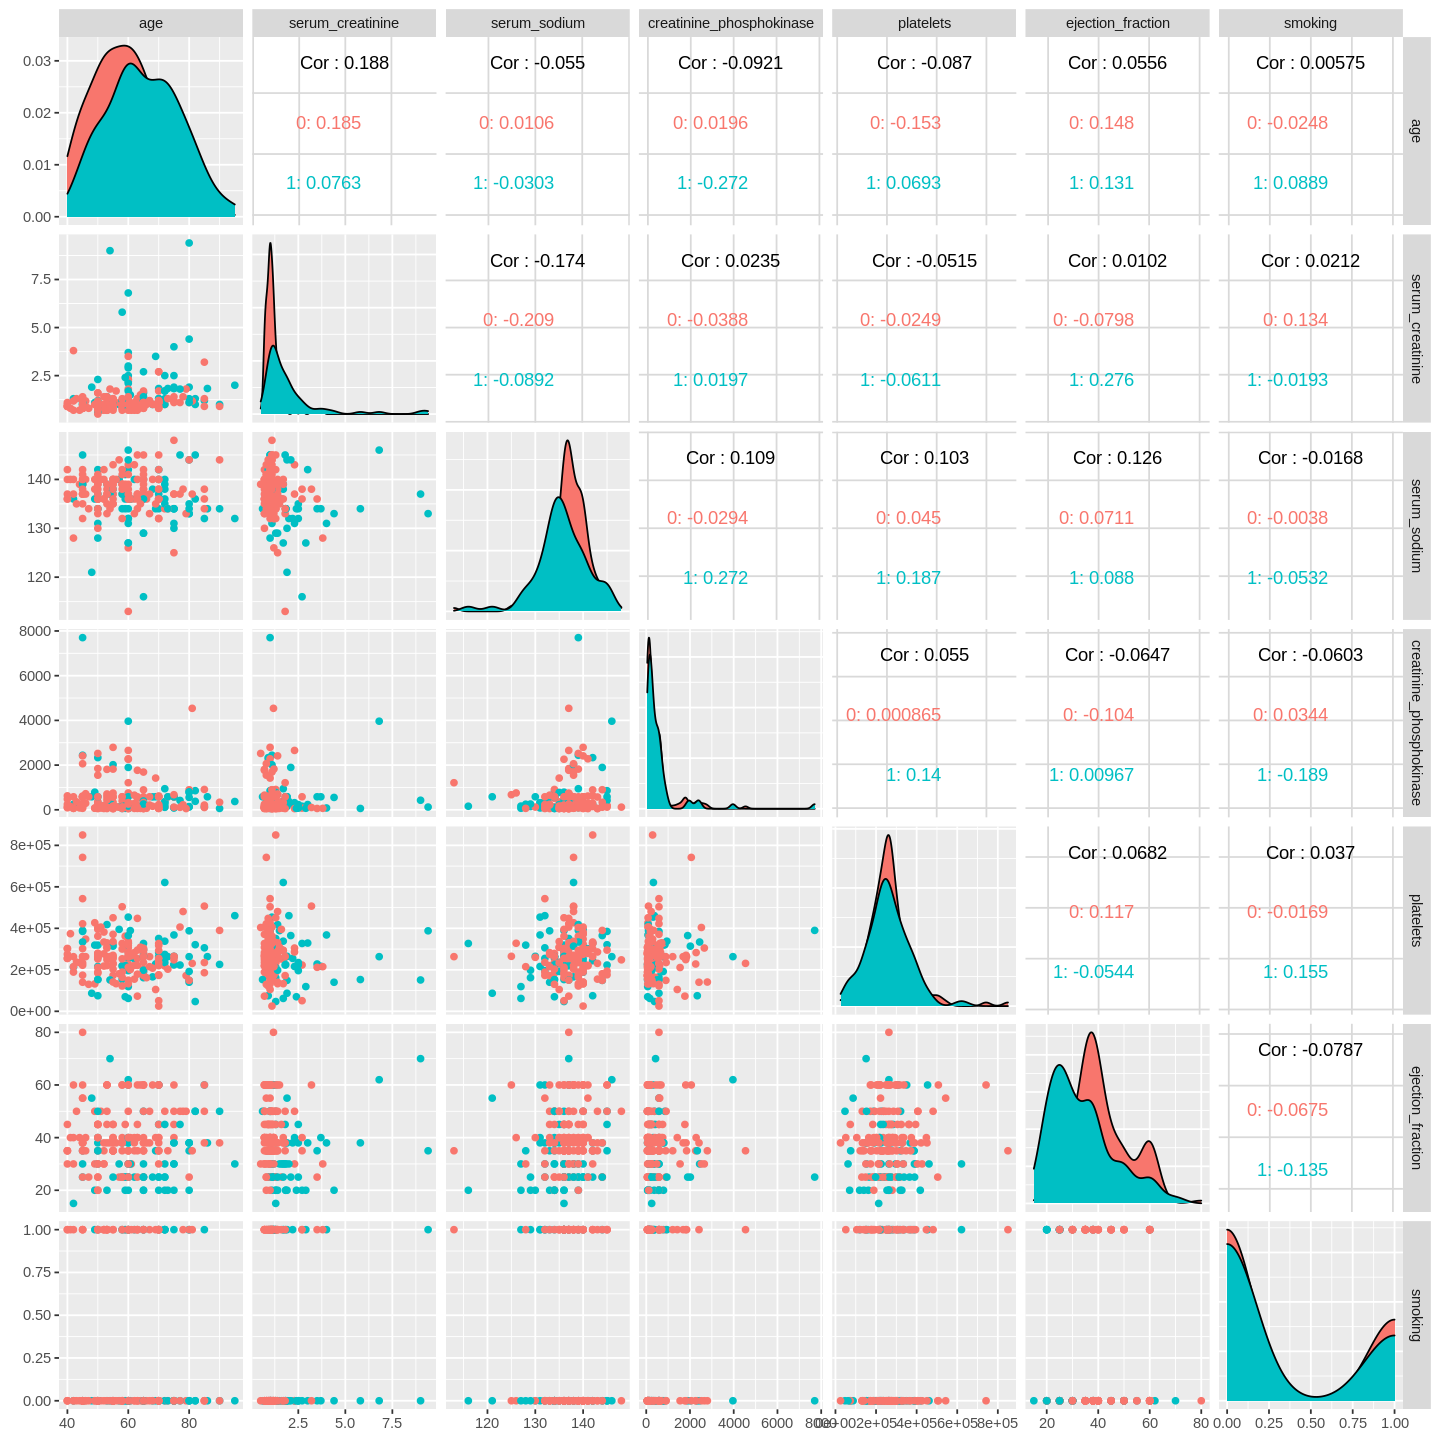

In [51]:
options(repr.plot.width = 12, repr.plot.height = 12)
heart_failure_plot1 <- ggpairs(heart_failure, columns=1:7, mapping=ggplot2::aes(colour=death)) 
heart_failure_plot1

From the graphs, we observed that age and ejection fraction was the best pair, as the smaller overlap in the dead and alive graphs shows that dead and alive people can be distinguished using these two predictors. There is a clear distribution in age and ejection fraction between those who were alive and those who died; hence, we will use these two as predictors for our model. We will plot these two variables and color the observations to further examine if there is a trend that can help us predict if someone would die.

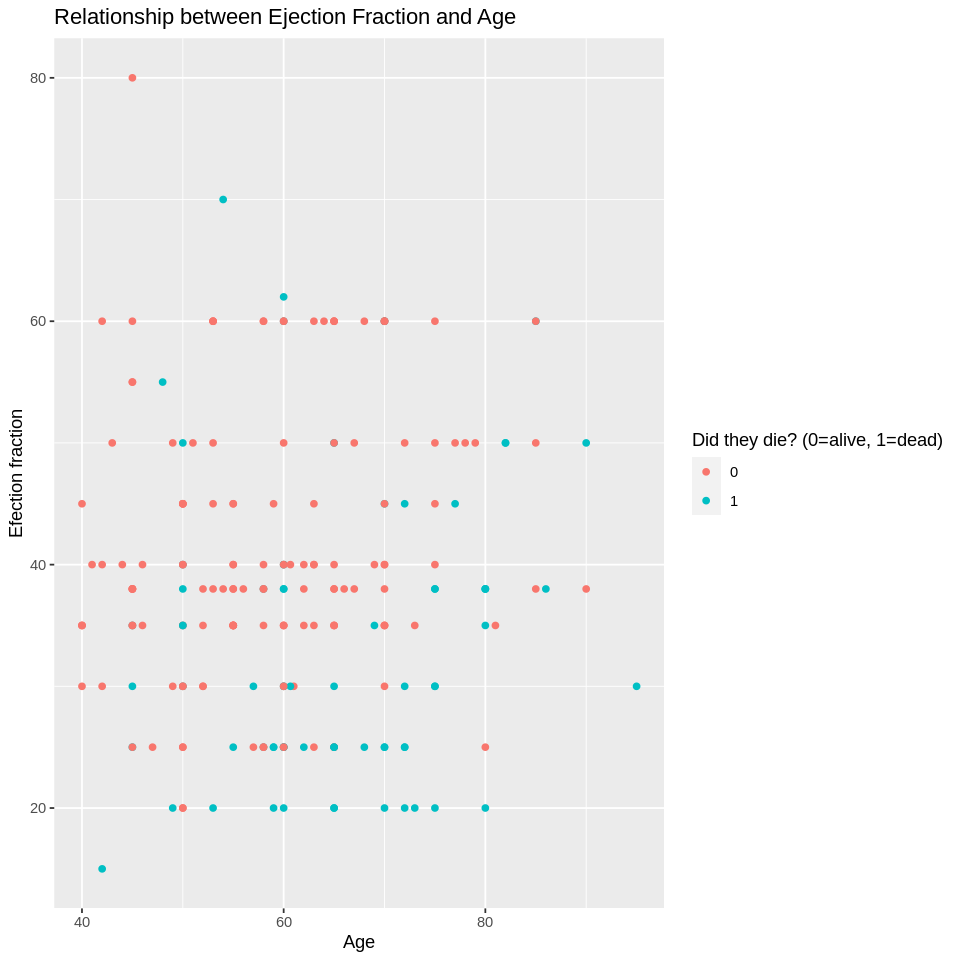

In [52]:
options(repr.plot.width = 8, repr.plot.height = 8)
heart_failure_plot2 <- ggplot(heart_failure, aes(x = age, y = ejection_fraction, color = death)) +
    geom_point() +
    xlab("Age") +
    ylab("Efection fraction") +
    labs(color = "Did they die? (0=alive, 1=dead)") +
    ggtitle("Relationship between Ejection Fraction and Age")
heart_failure_plot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



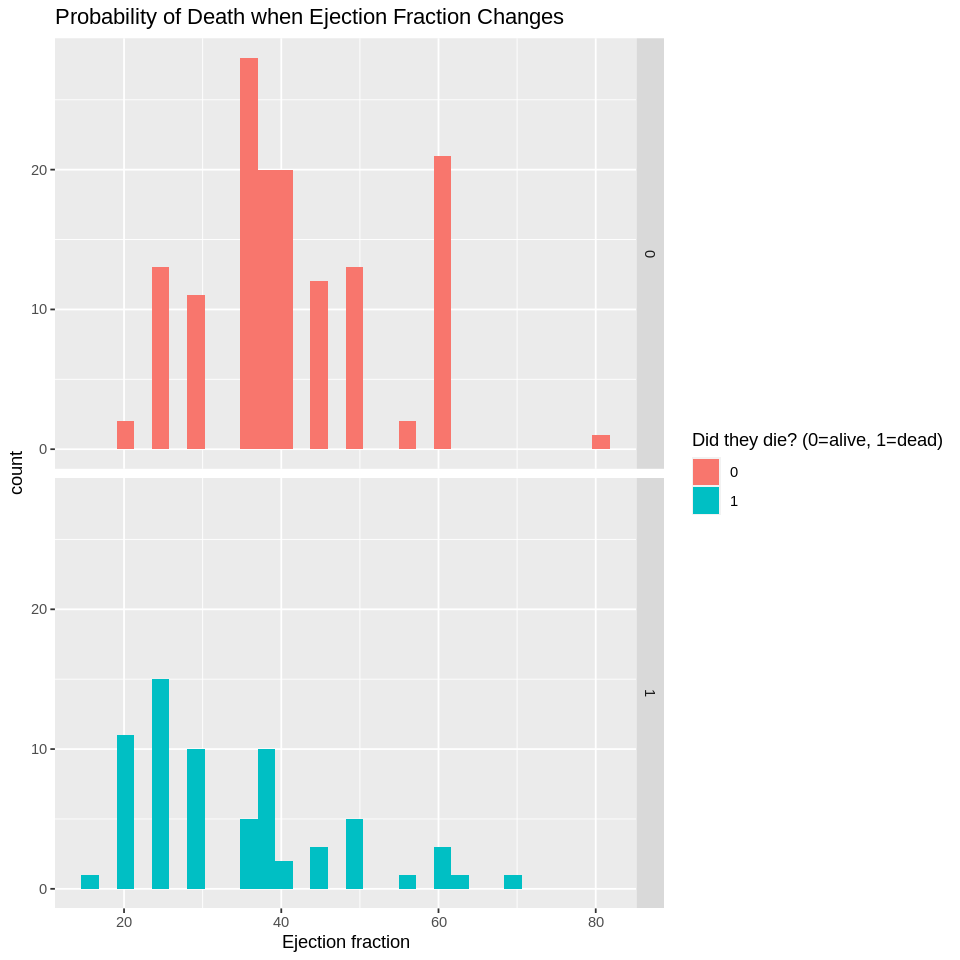

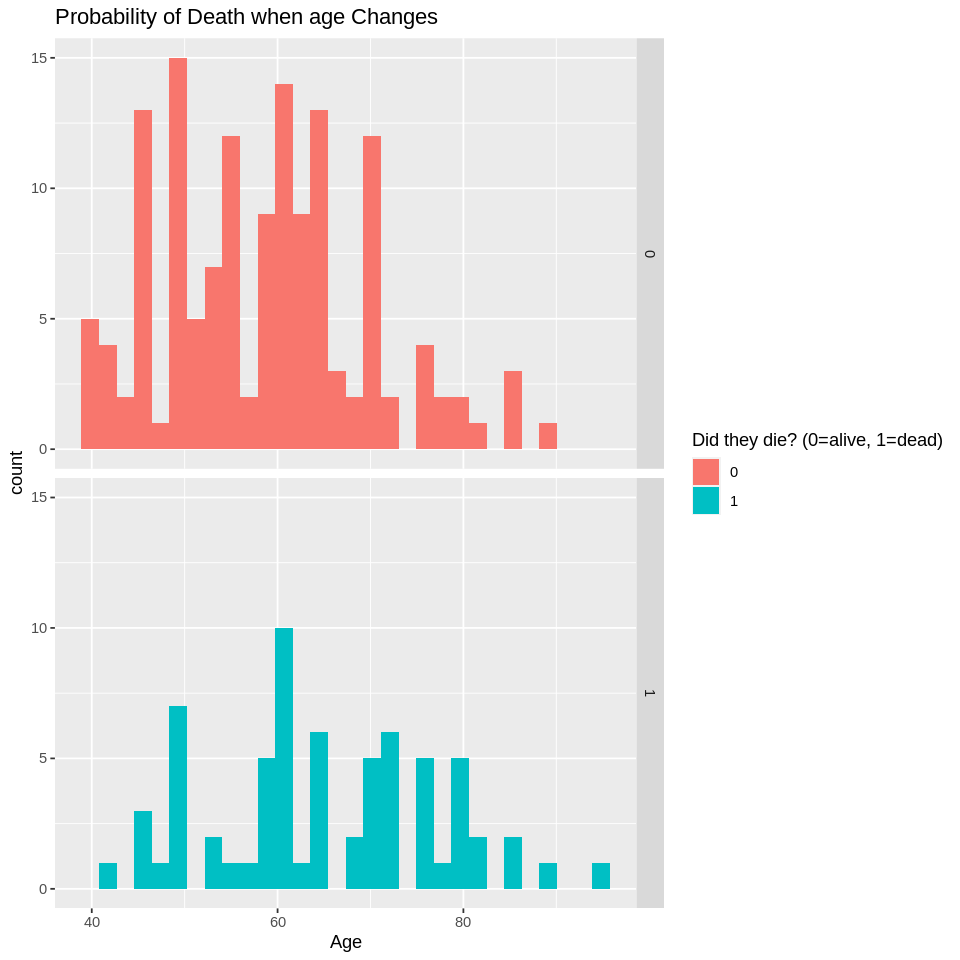

In [53]:
heart_failure_plot_ejection <- ggplot(heart_failure, aes(x = ejection_fraction, fill = death)) +
    geom_histogram(position="identity") +
    xlab("Ejection fraction") +
    labs(fill = "Did they die? (0=alive, 1=dead)") +
    ggtitle("Probability of Death when Ejection Fraction Changes")+
    facet_grid(death~.)
heart_failure_plot_ejection


heart_failure_plot_age <- ggplot(heart_failure, aes(x = age, fill = death)) +
    geom_histogram(position="identity") +
    xlab("Age") +
    labs(fill = "Did they die? (0=alive, 1=dead)") +
    ggtitle("Probability of Death when age Changes")+
    facet_grid(death~.)
heart_failure_plot_age

We expect that those with a higher age and lower ejection fraction to be associated with death due to heart disease, as the graphs also display that people with low ejection fraction or high age are more likely to die. Additionally,  age can cause one’s blood vessels and heart to change negatively; for example, the heart would tend to pump blood at a slower rate during physical activity. A low ejection fraction could indicate organs might not get enough blood to function. Hence, the graph and these facts would help us predict that a high age and low ejection fraction which would lead to death

**Method**

Using the 2 predictors, we will create a model to see if an individual will survive heart failure. Our model will use KNN classification, where we interpret relationships between the columns while colouring the points where death occured. This relationship will help determine a threshold where death is most likely. Putting an observation of a person into this model will help us predict if that person will die from heart failure. We can visualize it by putting our data point on to a scatterplot with our predictors as the axis, categorize each datapoint if they are dead or not, and see if they are within the thresholds that would predict them to be dead. 


**Future Questions**

Based on the model, what can we advise patients to do to increase their chances of surviving heart failure?
<br>Is this model reliable enough to help doctors with decisions?
